In [1]:
'''
initialize the world coordinates for a set of known points
- a point above the center of the arena
- center of each cache flap
'''
import os 
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage import measure

import sys
sys.path.append("../utils/")
from load_matlab_data import loadmat_sbx

In [2]:
# set the file paths
arena_folder = 'Z:/Isabel/arena/v0/arena_model/'
image_file = 'arena_model-01.png'
save_dir = "Z:/Isabel/presentations/230913_lab_meeting/"

In [3]:
# load the arena model image
img = mpimg.imread(arena_folder + image_file)
img = img[:, :, 0]

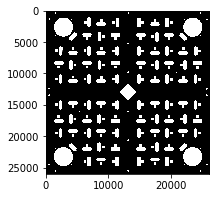

In [4]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(img, cmap='gray')
plt.show()

In [5]:
# get all the arena objects and their stats
blobs = img > 0.5
labels, num_blobs = measure.label(blobs, background=0, return_num=True)
props = measure.regionprops(labels)

In [6]:
# caches are larger than screws, smaller than perches
areas = np.asarray([])
for p in props:
    areas = np.append(areas, p.area)
cache_bool = (areas > 6e4) & (areas < 2e5)
cache_idx = np.arange(num_blobs)[cache_bool]
n_caches = np.sum(cache_bool)
assert n_caches == 84

In [7]:
# get the centroid for each cache
for i in cache_idx:
    if i == cache_idx[0]:
        cache_centers = props[i].centroid
    else:
        cache_centers = np.row_stack([cache_centers, props[i].centroid])

# format as x, y
cache_centers = np.flip(cache_centers, axis=1)

In [8]:
vals, bins = np.histogram(cache_centers[:, 0], bins=11)

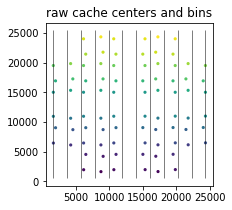

In [9]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
colors = np.linspace(0, 1, n_caches)
ax.scatter(cache_centers[:, 0], cache_centers[:, 1], 
           c=colors, cmap='viridis',
           alpha=1, lw=0, s=10)
lims = ax.get_ylim()
ax.vlines(bins, ymin=lims[0], ymax=lims[1], lw=0.5, colors='k')
ax.set_title('raw cache centers and bins')
plt.show()

In [10]:
# sort in order of the point index
for i, b0 in enumerate(bins[:-1]):
    b1 = bins[i+1]
    if i == 0:
        idx = cache_centers[:, 0] < b1
    elif b1 == bins[-1]:
        idx = cache_centers[:, 0] > b0
    else:
        idx = (cache_centers[:, 0] > b0) & (cache_centers[:, 0] < b1)
    caches = cache_centers[idx].copy()
    print(caches.shape[0])
    if i == 0:
        sorted_centers = caches
    else:
        sorted_centers = np.row_stack((sorted_centers, caches))

6
6
10
10
10
0
10
10
10
6
6


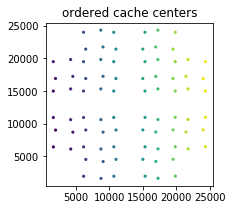

In [11]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(sorted_centers[:, 0], sorted_centers[:, 1], 
           c=colors, cmap='viridis',
           alpha=1, lw=0, s=10)
ax.set_title('ordered cache centers')
plt.show()

In [12]:
# normalize s.t. the arena is 2x2, centered at 0
half_len = img.shape[0] / 2
norm_centers = (sorted_centers / half_len) - 1

# convert to 3D
cache_pts_3d = np.column_stack((norm_centers, np.zeros(n_caches)))

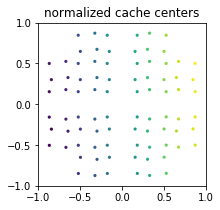

In [14]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(norm_centers[:, 0], norm_centers[:, 1], 
           c=colors, cmap='viridis',
           alpha=1, lw=0, s=10)
ax.set_xticks(np.arange(-1, 1.2, 0.5))
ax.set_yticks(np.arange(-1, 1.2, 0.5))
ax.set_title('normalized cache centers')

plt.show()
f.savefig(f'{save_dir}known_world_pts_2d.png', dpi=600, bbox_inches='tight')

In [15]:
# add the center point
center_pt = np.asarray([0, 0, 1/20])

In [16]:
# world point coords
world_coords = np.row_stack((center_pt, cache_pts_3d))

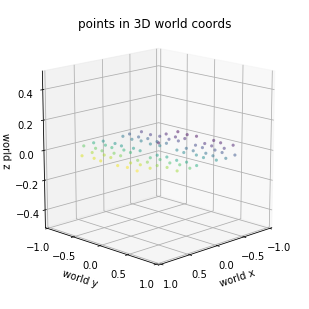

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4, 4))
ax = plt.axes([0, 0, 1, 1], projection='3d')

x_pts = world_coords[:, 0].copy()
y_pts = world_coords[:, 1].copy()
z_pts = world_coords[:, 2].copy()
colors = np.linspace(0, 1, n_caches+1)

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, cmap='viridis',
        alpha=0.5, lw=0, s=10)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-0.5, 0.5)

ax.set_xticks(np.arange(-1, 1.2, 0.5))
ax.set_yticks(np.arange(-1, 1.2, 0.5))

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=15)
ax.set_title('points in 3D world coords')

plt.show()
fig.savefig(f'{save_dir}known_world_pts_3d.png', dpi=600, bbox_inches='tight')

In [18]:
file_path = 'C:/Users/ilow1/Documents/Python Scripts/bird_pose_tracking/calibration_files/'
folder = 'known_points/'
np.save(f'{file_path}{folder}points_3d.npy', world_coords)